In [46]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from scipy import stats
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, expon
from sklearn.model_selection import train_test_split
from sklearn import set_config

set_config(transform_output='pandas')

pd.set_option('future.no_silent_downcasting', True)

sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)

In [2]:
IMAGES_PATH = Path().resolve().parent / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
data_path = Path().resolve().parent / "data"
data = pd.read_csv(data_path/"arbres_grenoble_epsg4326.csv")
arbres_df = data[data['anneedeplantation'].notnull()].reset_index(drop=True)
anne_null = data[data['anneedeplantation'].isnull()].reset_index(drop=True)
train_set, test_set = train_test_split(arbres_df, test_size=0.2, random_state=42)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)
train_feat = train_set.drop("anneedeplantation", axis=1).reset_index(drop=True)
train_target = train_set["anneedeplantation"].copy().reset_index(drop=True)

In [5]:
train_feat.head()

,elem_point_id,code,nom,genre,genre_desc,categorie,categorie_desc,sous_categorie,sous_categorie_desc,code_parent,...,diametrearbre,causeabattage,collectivite,stationmetro,hauteurarbre,portarbre,structure,forme,typenature,geo_point_2d
0,42864,ESP39815,AR39815,VEG,VEGETATION,ESP01,Arbre,ESP065,Arbre d'enceintes fermées,ESP198,...,NaN,NaN,Ville de Grenoble,NaN,Moins de 10 m,NaN,Ville de Grenoble,Tige,NaN,"45.1850108177391,5.724693809780337"
1,33628,ESP33882,AR33882,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP147,...,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.18892283178364,5.74310250008093"
2,17809,ESP5159,AR5159,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1395,...,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.16233714701438,5.735070761428521"
3,28018,ESP14125,AR14125,VEG,VEGETATION,ESP01,Arbre,ESP065,Arbre d'enceintes fermées,ESP659,...,NaN,NaN,Ville de Grenoble,NaN,de 10 m à 20 m,Libre,Ville de Grenoble,NaN,Libre,"45.16166695655946,5.707484188924904"
4,12618,ESP19277,AR19277,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP839,...,NaN,NaN,Ville de Grenoble,NaN,NaN,NaN,Ville de Grenoble,NaN,NaN,"45.170930550870274,5.703653444824306"


In [6]:
def stad_dev_name(function_transformer, feature_names_in):
    return ["stadededeveloppement"]  # feature names out

def stad_dev_transformer(X):
    X_copy = X.copy()
    X_copy["stadededeveloppement"] = X_copy["stadededeveloppement"].fillna(value="Arbre adulte")
    return X_copy[["stadededeveloppement"]]

def stad_dev_processor():
    return make_pipeline(
        FunctionTransformer(stad_dev_transformer, feature_names_out=stad_dev_name),
        )

class_order_stad = [["Arbre jeune", "Arbre adulte", "Arbre vieillissant"]]

ord_stad_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=class_order_stad, handle_unknown='use_encoded_value', unknown_value=-1)
    )

class_order_haut = [["Moins de 10 m", "de 10 m à 20 m", "Plus de 20 m"]]

ord_haut_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=class_order_haut, handle_unknown='use_encoded_value', unknown_value=-1)
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )

def portarbre_name(function_transformer, feature_names_in):
    return ["portarbre", "adr_secteur"]  # feature names out

def portarbre_transformer(X):
    X_copy = X.copy()
    mode_df = X_copy.groupby("adr_secteur")["portarbre"].agg(lambda x: x.mode().max()).reset_index()
    mode_df.columns = ["adr_secteur", "mode_portarbre"]
    for index, row in mode_df.iterrows():
        feat_value = row["adr_secteur"]
        mode_value = row["mode_portarbre"]
        X_copy.loc[X_copy["adr_secteur"] == feat_value, "portarbre"] = \
            X_copy.loc[X_copy["adr_secteur"] == feat_value, "portarbre"].fillna(value=mode_value)
        X_copy[["portarbre", "adr_secteur"]] = X_copy[["portarbre", "adr_secteur"]]
    return X_copy[["portarbre", "adr_secteur"]]

def portarbre_processor():
    return make_pipeline(
        FunctionTransformer(portarbre_transformer, feature_names_out=portarbre_name),
        )

def raison_name(function_transformer, feature_names_in):
    return ["raisondeplantation", "sous_categorie"]  # feature names out

def raison_transformer(X):
    X_copy = X.copy()
    mode_df = X_copy.groupby("sous_categorie")["raisondeplantation"].agg(lambda x: x.mode().max()).reset_index()
    mode_df.columns = ["sous_categorie", "mode_raison"]
    for index, row in mode_df.iterrows():
        feat_value = row["sous_categorie"]
        mode_value = row["mode_raison"]
        X_copy.loc[X_copy["sous_categorie"] == feat_value, "raisondeplantation"] = \
            X_copy.loc[X_copy["sous_categorie"] == feat_value, "raisondeplantation"].fillna(value=mode_value)
        X_copy[["raisondeplantation", "sous_categorie"]] = X_copy[["raisondeplantation", "sous_categorie"]]
    return X_copy[["raisondeplantation", "sous_categorie"]]

def raison_processor():
    return make_pipeline(
        FunctionTransformer(raison_transformer, feature_names_out=raison_name),
        )

def collect_name(function_transformer, feature_names_in):
    return ["collectivite", "sous_categorie"]  # feature names out

def collect_transformer(X):
    X_copy = X.copy()
    mode_df = X_copy.groupby("sous_categorie")["collectivite"].agg(lambda x: x.mode().max()).reset_index()
    mode_df.columns = ["sous_categorie", "mode_collec"]
    for index, row in mode_df.iterrows():
        feat_value = row["sous_categorie"]
        mode_value = row["mode_collec"]
        X_copy.loc[X_copy["sous_categorie"] == feat_value, "collectivite"] = \
            X_copy.loc[X_copy["sous_categorie"] == feat_value, "collectivite"].fillna(value=mode_value)
        X_copy[["collectivite", "sous_categorie"]] = X_copy[["collectivite", "sous_categorie"]]
    return X_copy[["collectivite", "sous_categorie"]]

def collect_processor():
    return make_pipeline(
        FunctionTransformer(collect_transformer, feature_names_out=collect_name),
        )

def haut_name(function_transformer, feature_names_in):
    return ["stadededeveloppement", "hauteurarbre"]  # feature names out

def haut_transformer(X):
    X_copy = X.copy()
    mode_df = X_copy.groupby("stadededeveloppement")["hauteurarbre"].agg(lambda x: x.mode().max()).reset_index()
    mode_df.columns = ["stadededeveloppement", "mode_haut"]
    for index, row in mode_df.iterrows():
        feat_value = row["stadededeveloppement"]
        mode_value = row["mode_haut"]
        X_copy.loc[X_copy["stadededeveloppement"] == feat_value, "hauteurarbre"] = \
            X_copy.loc[X_copy["stadededeveloppement"] == feat_value, "hauteurarbre"].fillna(value=mode_value)
        X_copy[["stadededeveloppement", "hauteurarbre"]] = X_copy[["stadededeveloppement", "hauteurarbre"]]
    return X_copy[["stadededeveloppement", "hauteurarbre"]]

def haut_processor():
    return make_pipeline(
        FunctionTransformer(haut_transformer, feature_names_out=haut_name),
        )

def struc_name(function_transformer, feature_names_in):
    return ["structure", "sous_categorie"]  # feature names out

def struc_transformer(X):
    X_copy = X.copy()
    mode_df = train_feat.groupby("sous_categorie")["structure"].agg(lambda x: x.mode().max()).reset_index()
    mode_df.columns = ["sous_categorie", "mode_struc"]
    for index, row in mode_df.iterrows():
        feat_value = row["sous_categorie"]
        mode_value = row["mode_struc"]
        train_feat.loc[train_feat["sous_categorie"] == feat_value, "structure"] = \
            train_feat.loc[train_feat["sous_categorie"] == feat_value, "structure"].fillna(value=mode_value)
        X_copy[["structure", "sous_categorie"]] = X_copy[["structure", "sous_categorie"]]
    return X_copy[["structure", "sous_categorie"]]

def struc_processor():
    return make_pipeline(
        FunctionTransformer(struc_transformer, feature_names_out=struc_name),
        )

def adr_secteur_name(function_transformer, feature_names_in):
    return ["adr_secteur"]  # feature names out

def transf_adr_secteur(X):
    X_copy = X.copy()
    conditions = [
        (X_copy["adr_secteur"] == 1),
        (X_copy["adr_secteur"] == 2),
        (X_copy["adr_secteur"] == 3),
        (X_copy["adr_secteur"] == 4),
        (X_copy["adr_secteur"] == 5),
        (X_copy["adr_secteur"] == 6),
        (X_copy["adr_secteur"] > 6),
    ]
    categories = [1, 2, 3, 4, 5, 6, 100]
    X_copy["adr_secteur"] = np.select(conditions, categories, default='Unknown')
    X_copy['adr_secteur'] = X_copy['adr_secteur'].apply(str)
    return X_copy[["adr_secteur"]]

adr_secteur_pipeline = make_pipeline(
    FunctionTransformer(transf_adr_secteur, feature_names_out=adr_secteur_name)
)

# Defining the preprocessing steps
preprocessing_initial = ColumnTransformer([
        ("fill_na_state_dev", stad_dev_processor(), ["stadededeveloppement"]),
        ("fill_na_portarbre", portarbre_processor(), ["portarbre", "adr_secteur"]),
        ("fill_na_raison", raison_processor(), ["raisondeplantation", "sous_categorie"])],
        remainder='passthrough',
        verbose_feature_names_out=False
)

preprocessing_sec = ColumnTransformer([
        ("fill_na_collectivite", collect_processor(), ["collectivite", "sous_categorie"]),
        ("fill_na_haut", haut_processor(), ["hauteurarbre", "stadededeveloppement"])],
        remainder='passthrough',
        verbose_feature_names_out=False
)

preprocessing_thr = ColumnTransformer([
        ("state_dev", ord_stad_pipeline, ["stadededeveloppement"]),
        ("haut_ord", ord_haut_pipeline, ["hauteurarbre"]),
        ("fill_na_struc", struc_processor(), ["structure", "sous_categorie"])],
        remainder='passthrough',
        verbose_feature_names_out=False
)

preprocessing_adr_secteur = ColumnTransformer(
	[("adr_secteur_obj", adr_secteur_pipeline, ['adr_secteur'])],
	remainder='passthrough',
	verbose_feature_names_out=False
)

preprocessing_cat = ColumnTransformer(
    [("cat", cat_pipeline, ["sous_categorie", "raisondeplantation", "collectivite",
                            "portarbre", "structure", "adr_secteur"])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

class DropColumnsTransformer:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)
    
    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# Define the columns you want to drop
columns_to_drop = ["elem_point_id", "code", "nom", "genre", "genre_desc", "categorie",
                   "categorie_desc", "sous_categorie_desc", "code_parent", "code_parent_desc",
                   "bien_reference", "genre_bota", "espece", "variete", "equipe", "remarques",
                   "courrier", "identifiantplu", "typeimplantationplu", "intituleprotectionplu",
                   "anneeabattage", "essouchement", "diametrearbre", "causeabattage",
                   "stationmetro", "forme", "typenature", "traitementchenilles", "geo_point_2d"]

# Transformer to drop those columns
preprocessing_drop_columns = DropColumnsTransformer(columns=columns_to_drop)

# Combine all transformers in a pipeline
preprocessor = make_pipeline(
    preprocessing_initial,
    preprocessing_sec,
    preprocessing_thr,
    preprocessing_adr_secteur,
    preprocessing_cat,
    preprocessing_drop_columns
)

In [7]:
X_train = preprocessor.fit_transform(train_feat)
X_train.shape

(23804, 27)

In [8]:
X_train.head()

,sous_categorie_ESP065,sous_categorie_ESP151,sous_categorie_ESP174,sous_categorie_ESP187,raisondeplantation_Existant,raisondeplantation_Nouveau,raisondeplantation_Remplacement,collectivite_Grenoble Alpes Métropole,collectivite_Ville de Grenoble,portarbre_Architecturé,...,structure_Ville de Grenoble,adr_secteur_1,adr_secteur_100,adr_secteur_2,adr_secteur_3,adr_secteur_4,adr_secteur_5,adr_secteur_6,stadededeveloppement,hauteurarbre
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23804 entries, 0 to 23803
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   sous_categorie_ESP065                  23804 non-null  float64
 1   sous_categorie_ESP151                  23804 non-null  float64
 2   sous_categorie_ESP174                  23804 non-null  float64
 3   sous_categorie_ESP187                  23804 non-null  float64
 4   raisondeplantation_Existant            23804 non-null  float64
 5   raisondeplantation_Nouveau             23804 non-null  float64
 6   raisondeplantation_Remplacement        23804 non-null  float64
 7   collectivite_Grenoble Alpes Métropole  23804 non-null  float64
 8   collectivite_Ville de Grenoble         23804 non-null  float64
 9   portarbre_Architecturé                 23804 non-null  float64
 10  portarbre_Libre                        23804 non-null  float64
 11  po

In [10]:
preprocessor

/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fill_na_state_dev',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function stad_dev_name at 0x7ea6282afce0>,
                                                                                       func=<function stad_dev_transformer at 0x7ea6282af880>))]),
                                                  ['stadededeveloppement']),
                                                 ('fill_na_portarbre',
                                                  Pipeline(steps...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sous_categorie',
                                                   'raisondeplantation',
                                                   'collectivite', 'portarbre',
                                                   'structure',
                                                   'adr_secteur'])],
                                   verbose_feature_names_out=False)),
                ('dropcolumnstransformer',
                 <__main__.DropColumnsTransformer object at 0x7ea627d0f920>)])

In [11]:
preprocessor.get_feature_names_out()

['sous_categorie_ESP065',
 'sous_categorie_ESP151',
 'sous_categorie_ESP174',
 'sous_categorie_ESP187',
 'raisondeplantation_Existant',
 'raisondeplantation_Nouveau',
 'raisondeplantation_Remplacement',
 'collectivite_Grenoble Alpes Métropole',
 'collectivite_Ville de Grenoble',
 'portarbre_Architecturé',
 'portarbre_Libre',
 'portarbre_Pleureur',
 'portarbre_Pyramidale',
 'portarbre_Semi-libre',
 'structure_CCAS',
 'structure_Ecole',
 'structure_Métropole de Grenoble',
 'structure_Ville de Grenoble',
 'adr_secteur_1',
 'adr_secteur_100',
 'adr_secteur_2',
 'adr_secteur_3',
 'adr_secteur_4',
 'adr_secteur_5',
 'adr_secteur_6',
 'stadededeveloppement',
 'hauteurarbre']

In [12]:
y_train = train_target
y_train

0        2017.0
1        2015.0
2        1975.0
3        1999.0
4        1994.0
          ...  
23799    2014.0
23800    1978.0
23801    2017.0
23802    2000.0
23803    2015.0
Name: anneedeplantation, Length: 23804, dtype: float64

## DummyRegressor

In [47]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [48]:
X_test = preprocessor.transform(test_set)
y_pred = dummy_reg.predict(X_test)
y_pred

array([1987., 1987., 1987., ..., 1987., 1987., 1987.])

In [51]:
y_test = test_set["anneedeplantation"].copy().reset_index(drop=True)

dummy_mse_test = mean_squared_error(y_test, y_pred)
print('test dummy MSE: {0}'.format(dummy_mse_test))

test dummy MSE: 335.04200268817203


### Model 1

In [13]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

LinearRegression()

In [14]:
X_test = preprocessor.transform(test_set)
y_pred = model_lin.predict(X_test)
y_pred

array([1981.09375 , 1996.609375, 1995.21875 , ..., 1987.078125,
       2007.625   , 1995.109375])

In [15]:
y_test = test_set["anneedeplantation"].copy().reset_index(drop=True)

In [16]:
mse_test = mean_squared_error(y_test, y_pred)
print('test linear regression MSE: {0}'.format(mse_test))

test MSE: 2.2144338119588082e+21


In [17]:
print(mean_absolute_error(y_test, y_pred))

1056478158.5916184


### Model 2

In [18]:
model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [19]:
y_pred_dtr = model_dtr.predict(X_test)
mse_dtr_test = mean_squared_error(y_test, y_pred_dtr)
print('test MSE for DTR: {0}'.format(mse_dtr_test))

y_pred_train = model_dtr.predict(X_train)
mse_dtr_train = mean_squared_error(y_train, y_pred_train)
print('training MSE for DTR: {0}'.format(mse_dtr_train))

rmse_dtr_test = np.sqrt(mse_dtr_test)
print('RMSE for DTR: {0}'.format(rmse_dtr_test))

mean  = np.mean(y_train)
std = np.std(y_train)
print('Mean (standard deviation) values of target variables in train set for DTR: {0} ({1})'.format(mean, std))

test MSE for DTR: 183.98943674025253
training MSE for DTR: 180.44454176953994
RMSE for DTR: 13.564270593741947
Mean (standard deviation) values of target variables in train set for DTR: 1990.4111493866576 (18.193942341692487)


### Model 3

In [20]:
model_svr = SVR()
model_svr.fit(X_train, y_train)

SVR()

In [21]:
y_pred_svr = model_svr.predict(X_test)
mse_svr_test = mean_squared_error(y_test, y_pred_svr)
print('test MSE for SVR: {0}'.format(mse_svr_test))

y_pred_train = model_svr.predict(X_train)
mse_svr_train = mean_squared_error(y_train, y_pred_train)
print('training MSE for SVR: {0}'.format(mse_svr_train))

rmse_svr_test = np.sqrt(mse_svr_test)
print('RMSE for SVR: {0}'.format(rmse_svr_test))

mean  = np.mean(y_train)
std = np.std(y_train)
print('Mean (standard deviation) values of target variables in train set for SVR: {0} ({1})'.format(mean, std))

test MSE for SVR: 205.3549545670038
training MSE for SVR: 206.32420331895335
RMSE for SVR: 14.330211253397621
Mean (standard deviation) values of target variables in train set for SVR: 1990.4111493866576 (18.193942341692487)


# CV scores

In [56]:
lin_reg_scores = cross_val_score(model_lin, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
-lin_reg_scores.mean()

2.1551285473268164e+20

In [55]:
dtr_scores = cross_val_score(model_dtr, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
-dtr_scores.mean()

186.20942097242084

In [24]:
svr_scores = cross_val_score(model_svr, X_train, y_train, cv=10, n_jobs=-1)
svr_scores.mean()

0.37084129847720193

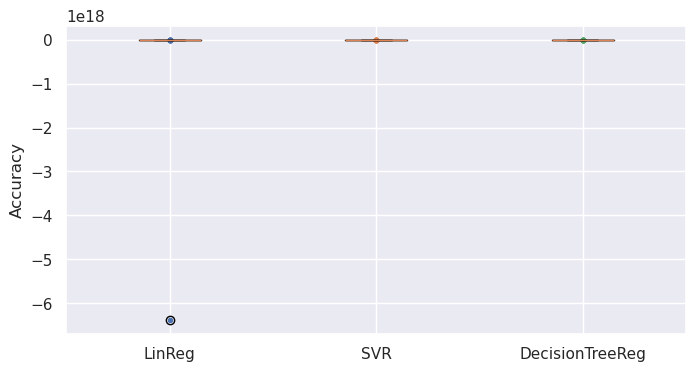

In [25]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, lin_reg_scores, ".")
plt.plot([2]*10, dtr_scores, ".")
plt.plot([3]*10, svr_scores, ".")
plt.boxplot([lin_reg_scores, dtr_scores, svr_scores], labels=("LinReg", "SVR", "DecisionTreeReg"))
plt.ylabel("Accuracy")
plt.show()

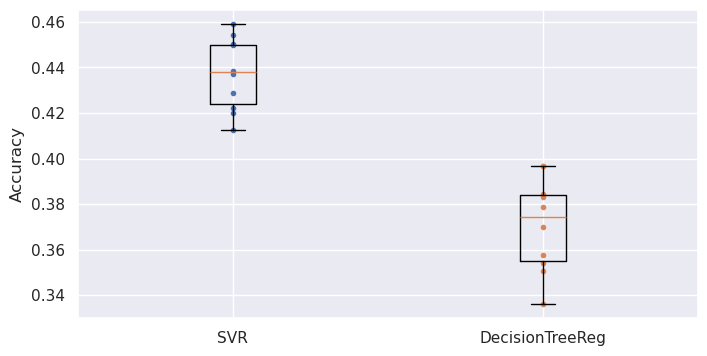

In [26]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, dtr_scores, ".")
plt.plot([2]*10, svr_scores, ".")
plt.boxplot([dtr_scores, svr_scores], labels=("SVR", "DecisionTreeReg"))
plt.ylabel("Accuracy")
plt.show()

In [27]:
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

svr_pipeline = Pipeline([("preprocessor", preprocessor), ("svr", SVR())])
svr_rnd_search = RandomizedSearchCV(svr_pipeline,
                                    param_distributions=param_distribs,
                                    n_iter=10, cv=3,
                                    scoring="neg_mean_squared_error",
                                    verbose=2,
                                    n_jobs=-1,
                                    random_state=42)

svr_rnd_search.fit(train_feat, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=  56.7s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=  58.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time= 1.0min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=84.1410790057587, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time= 1.1min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=84.1410790057587, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time= 1.1min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=24.175082946113907, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=  48.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=84.1410790057587, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time= 1.0min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=24.175082946113907, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=  47.9s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=24.175082946113907, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=  47.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=432.3788481314884, svr__gamma=0.15416196746656105, svr__kernel=linear; total time= 2.8min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=432.3788481314884, svr__gamma=0.15416196746656105, svr__kernel=linear; total time= 3.0min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time= 4.2min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time= 4.2min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time= 4.3min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=432.3788481314884, svr__gamma=0.15416196746656105, svr__kernel=linear; total time= 3.3min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=108.3048823880507, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=  52.6s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=108.3048823880507, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=  52.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=21.344953672647428, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=  50.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=108.3048823880507, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=  52.7s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=21.344953672647428, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=  50.5s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=21.344953672647428, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=  47.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=  56.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=  53.7s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time= 1.5min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time= 1.7min
[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time= 1.9min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=  53.7s
[CV] END svr__C=113564.03940586242, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time= 3.3min


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END svr__C=113564.03940586242, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time= 4.8min
[CV] END svr__C=113564.03940586242, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time= 4.8min


/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('columntransformer-1',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('fill_na_state_dev',
                                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                                 FunctionTransformer(feature_names_out=<function stad_dev_name at 0x7ea6282afce0>,
                                                                                                                                     func=<function stad_dev_transformer at 0x7ea6282af880>...
                                                               <__main__.DropColumnsTransformer object at 0x7ea627d0f920>)])),
                                             ('svr', SVR())]),
                   n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ea628161ee0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ea627d0d610>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [44]:
pd.DataFrame(svr_rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,244.110791,2.684053,8.724673,0.379983,629.782330,3.010121,linear,"{'svr__C': 629.782329591372, 'svr__gamma': 3.0...",-234.098692,-230.030787,-237.813880,-233.981120,3.178522,9
1,43.005991,2.029999,15.763555,0.177900,26290.206464,0.908447,rbf,"{'svr__C': 26290.20646430022, 'svr__gamma': 0....",-221.905965,-218.748202,-217.363104,-219.339090,1.901098,3
2,47.090601,2.478506,17.110115,0.228526,84.141079,0.059839,rbf,"{'svr__C': 84.1410790057587, 'svr__gamma': 0.0...",-218.606286,-208.891320,-215.200304,-214.232637,4.024709,1
3,174.685710,11.431837,8.362457,0.264565,432.378848,0.154162,linear,"{'svr__C': 432.3788481314884, 'svr__gamma': 0....",-234.098527,-230.030380,-237.813047,-233.980651,3.178353,8
4,32.520089,0.238928,15.289100,0.203792,24.175083,3.503557,rbf,"{'svr__C': 24.175082946113907, 'svr__gamma': 3...",-222.697334,-220.210084,-217.437157,-220.114858,2.148514,5
5,242.879517,42.034919,14.675272,0.048335,113564.039406,0.000779,rbf,"{'svr__C': 113564.03940586242, 'svr__gamma': 0...",-233.572347,-222.500298,-229.205875,-228.426173,4.553645,7
6,37.299348,0.282648,15.171396,0.373200,108.304882,0.362754,rbf,"{'svr__C': 108.3048823880507, 'svr__gamma': 0....",-221.861214,-216.759439,-217.854640,-218.825098,2.192923,2
7,41.089808,1.406619,8.304624,0.087999,21.344954,0.023333,linear,"{'svr__C': 21.344953672647428, 'svr__gamma': 0...",-234.100081,-230.030890,-237.813881,-233.981617,3.178497,10
8,89.338354,9.816798,13.977972,0.286613,5603.270317,0.150235,rbf,"{'svr__C': 5603.270317432522, 'svr__gamma': 0....",-222.695164,-220.360568,-218.772245,-220.609326,1.611156,6
9,40.409270,1.321759,14.072014,0.298339,157055.109894,0.264970,rbf,"{'svr__C': 157055.10989448498, 'svr__gamma': 0...",-222.359468,-219.502265,-218.290506,-220.050746,1.705820,4


In [34]:
svr_rnd_search.best_params_

{'svr__C': 84.1410790057587,
 'svr__gamma': 0.059838768608680676,
 'svr__kernel': 'rbf'}

In [29]:
selector_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(DecisionTreeRegressor(random_state=42),
                                 threshold=0.005)),
    ('svr', SVR(C=svr_rnd_search.best_params_["svr__C"],
                gamma=svr_rnd_search.best_params_["svr__gamma"],
                kernel=svr_rnd_search.best_params_["svr__kernel"])),
])

In [30]:
selector_rmses = cross_val_score(selector_pipeline,
                                  train_feat,
                                  train_target,
                                  scoring="neg_mean_squared_error",
                                  cv=5,
                                  n_jobs=-1)
pd.Series(selector_rmses).describe()

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

count      5.000000
mean    -214.305364
std        4.986291
min     -219.831153
25%     -216.968763
50%     -216.488803
75%     -210.396014
max     -207.842089
dtype: float64

In [35]:
final_model = svr_rnd_search.best_estimator_
final_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fill_na_state_dev',
                                                                   Pipeline(steps=[('functiontransformer',
                                                                                    FunctionTransformer(feature_names_out=<function stad_dev_name at 0x7ea6282afce0>,
                                                                                                        func=<function stad_dev_transformer at 0x7ea6282af880>))]),
                                                                   ['stadededeveloppement']),
                                                                  ('f...
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['sous_categorie',
                                                                    'raisondeplantation',
                                                                    'collectivite',
                                                                    'portarbre',
                                                                    'structure',
                                                                    'adr_secteur'])],
                                                    verbose_feature_names_out=False)),
                                 ('dropcolumnstransformer',
                                  <__main__.DropColumnsTransformer object at 0x7ea6280ecd10>)])),
                ('svr', SVR(C=84.1410790057587, gamma=0.059838768608680676))])

In [32]:
final_predictions = final_model.predict(test_set)
final_predictions

array([1978.1002011 , 2012.49047814, 2003.08580212, ..., 1985.09943138,
       2015.10009496, 2000.09937725])

In [33]:
final_y_preds = final_model.predict(test_set)
mse_fin_test = mean_squared_error(y_test, final_y_preds)
print('test MSE for final model: {0}'.format(mse_fin_test))

final_y_train_preds = final_model.predict(train_set)
mse_fin_train = mean_squared_error(y_train, final_y_train_preds)
print('training MSE for final model: {0}'.format(mse_fin_train))

rmse_fin_test = np.sqrt(mse_fin_test)
print('RMSE for final model: {0}'.format(rmse_fin_test))

mean  = np.mean(y_train)
std = np.std(y_train)
print('Mean (standard deviation) values of target variables in train set for final model: {0} ({1})'.format(mean, std))

test MSE for final model: 206.59309623995546
training MSE for final model: 209.81100322786511
RMSE for final model: 14.373346730666295
Mean (standard deviation) values of target variables in train set for final model: 1990.4111493866576 (18.193942341692487)


## Final model predictions for unseen data

In [58]:
predictions_for_new_data = final_model.predict(anne_null)
predictions_for_new_data

array([1995.02198472, 1995.02198472, 1995.02198472, ..., 1976.09970235,
       1995.76168274, 1976.91440063])

## Inverting the final model ordering

In [37]:
dtr_param_distribs = {
	"dtr__splitter": ["best", "random"],
    "dtr__max_depth": [1, 3, 5, 7, 9, 11, 12, 15, 20, 50, 100],
    "dtr__min_samples_leaf": [1, 2, 3, 4, 5, 10, 11, 12, 15, 20, 30, 40, 50, 100, 150, 200, 1000],
    "dtr__min_weight_fraction_leaf": [0, 0.001, 0.01, 0.1, 0.15, 0.2, 0.22, 0.26, 0.3, 0.33, 0.38, 0.4, 0.5],
    "dtr__max_features": ["log2", "sqrt"],
    "dtr__max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    }

In [38]:
dtr_pipeline = Pipeline([("preprocessor", preprocessor), ("dtr", DecisionTreeRegressor())])

dtr_rnd_search = RandomizedSearchCV(dtr_pipeline,
                                    param_distributions=dtr_param_distribs,
                                    n_iter=10, cv=10,
                                    scoring="neg_mean_squared_error",
                                    verbose=2,
                                    n_jobs=-1,
                                    random_state=42)

In [39]:
dtr_rnd_search.fit(train_feat, train_target)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.1s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.3s
[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.4s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.3s
[CV] END dtr__max_depth=3, dtr__max_features=sqrt, dtr__max_leaf_nodes=50, dtr__min_samples_leaf=50, dtr__min_weight_fraction_leaf=0.22, dtr__splitter=random; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=log2, dtr__max_leaf_nodes=10, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.001, dtr__splitter=best; total time=   1.2s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   0.9s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   0.9s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=20, dtr__max_features=sqrt, dtr__max_leaf_nodes=30, dtr__min_samples_leaf=100, dtr__min_weight_fraction_leaf=0.3, dtr__splitter=best; total time=   1.2s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.3s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   0.9s
[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=4, dtr__min_weight_fraction_leaf=0, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s


a, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects

[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s
[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=1, dtr__max_features=sqrt, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.5, dtr__splitter=random; total time=   1.0s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.2s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.1s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.3s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.5s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   0.9s
[CV] END dtr__max_depth=50, dtr__max_features=log2, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=11, dtr__min_weight_fraction_leaf=0.33, dtr__splitter=best; total time=   1.3s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.2s
[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=log2, dtr__max_leaf_nodes=40, dtr__min_samples_leaf=3, dtr__min_weight_fraction_leaf=0.26, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.4s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.2s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.1s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.0s
[CV] END dtr__max_depth=50, dtr__max_features=sqrt, dtr__max_leaf_nodes=70, dtr__min_samples_leaf=1000, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=best; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.0s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.1s

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln


[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=9, dtr__max_features=sqrt, dtr__max_leaf_nodes=90, dtr__min_samples_leaf=150, dtr__min_weight_fraction_leaf=0.15, dtr__splitter=random; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.0s
[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.2s
[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.1s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   0.9s
[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.2s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   1.1s
[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   0.9s
[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   0.9s


/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


[CV] END dtr__max_depth=12, dtr__max_features=sqrt, dtr__max_leaf_nodes=60, dtr__min_samples_leaf=10, dtr__min_weight_fraction_leaf=0.38, dtr__splitter=random; total time=   0.9s


/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('columntransformer-1',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('fill_na_state_dev',
                                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                                 FunctionTransformer(feature_names_out=<function stad_dev_name at 0x7ea6282afce0>,
                                                                                                                                     func=<function stad_dev_transformer at 0x7ea6282af880...
                                        'dtr__max_features': ['log2', 'sqrt'],
                                        'dtr__max_leaf_nodes': [None, 10, 20,
                                                                30, 40, 50, 60,
                                                                70, 80, 90],
                                        'dtr__min_samples_leaf': [1, 2, 3, 4, 5,
                                                                  10, 11, 12,
                                                                  15, 20, 30,
                                                                  40, 50, 100,
                                                                  150, 200,
                                                                  1000],
                                        'dtr__min_weight_fraction_leaf': [0,
                                                                          0.001,
                                                                          0.01,
                                                                          0.1,
                                                                          0.15,
                                                                          0.2,
                                                                          0.22,
                                                                          0.26,
                                                                          0.3,
                                                                          0.33,
                                                                          0.38,
                                                                          0.4,
                                                                          0.5],
                                        'dtr__splitter': ['best', 'random']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [45]:
pd.DataFrame(dtr_rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtr__splitter,param_dtr__min_weight_fraction_leaf,param_dtr__min_samples_leaf,param_dtr__max_leaf_nodes,param_dtr__max_features,param_dtr__max_depth,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.923734,0.094357,0.291326,0.037240,random,0.220,50,50,sqrt,3,...,-306.483036,-311.896590,-325.557985,-319.058161,-316.500812,-337.998967,-322.023339,-315.170423,20.490290,7
1,0.832475,0.084003,0.301039,0.067093,best,0.001,1000,10,log2,1,...,-313.113998,-278.505659,-312.227434,-294.455593,-284.682283,-324.391326,-259.231650,-292.735195,23.510025,2
2,0.785173,0.074798,0.251627,0.020178,best,0.300,100,30,sqrt,20,...,-258.937700,-313.374482,-325.557985,-315.564528,-317.048499,-324.347157,-322.023339,-315.149149,19.626909,6
3,0.875656,0.107544,0.295999,0.066693,best,0.000,4,40,log2,12,...,-240.095558,-223.522928,-223.111649,-241.182777,-306.416142,-244.492351,-255.628736,-244.833152,23.145014,1
4,0.782854,0.057880,0.262965,0.028637,random,0.500,3,40,sqrt,1,...,-326.354054,-319.210064,-325.557985,-329.752829,-328.523484,-337.998967,-330.179683,-331.036553,7.209104,10
5,0.894312,0.104246,0.307992,0.043733,best,0.330,11,60,log2,50,...,-326.354054,-311.896590,-259.426289,-315.564528,-328.523484,-325.912634,-330.179683,-317.887728,20.794953,8
6,0.824018,0.080924,0.277621,0.035360,best,0.260,3,40,log2,9,...,-326.354054,-319.210064,-312.227434,-315.564528,-328.523484,-324.347157,-320.903509,-310.421719,23.650530,4
7,0.820043,0.088849,0.280720,0.030721,best,0.150,1000,70,sqrt,50,...,-308.924548,-272.449917,-282.957616,-316.960005,-317.319423,-292.516181,-254.028490,-300.654239,23.935053,3
8,0.830210,0.071907,0.299255,0.046820,random,0.150,150,90,sqrt,9,...,-310.639162,-274.204624,-311.100692,-316.352004,-315.771618,-324.383061,-321.807136,-311.159100,15.841355,5
9,0.791904,0.115820,0.246928,0.031625,random,0.380,10,60,sqrt,12,...,-326.354054,-319.210064,-312.227434,-329.752829,-317.253140,-325.942254,-330.179683,-324.632783,8.956099,9


In [40]:
dtr_rnd_search.best_params_

{'dtr__splitter': 'best',
 'dtr__min_weight_fraction_leaf': 0,
 'dtr__min_samples_leaf': 4,
 'dtr__max_leaf_nodes': 40,
 'dtr__max_features': 'log2',
 'dtr__max_depth': 12}

In [41]:
dtr_selector_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(SVR(),
                                 threshold=0.005)),
    ('dtr', DecisionTreeRegressor(
                splitter=dtr_rnd_search.best_params_["dtr__splitter"],
                min_weight_fraction_leaf=dtr_rnd_search.best_params_["dtr__min_weight_fraction_leaf"],
                min_samples_leaf=dtr_rnd_search.best_params_["dtr__min_samples_leaf"],
                max_leaf_nodes=dtr_rnd_search.best_params_["dtr__max_leaf_nodes"],
                max_features=dtr_rnd_search.best_params_["dtr__max_features"],
                max_depth=dtr_rnd_search.best_params_["dtr__max_depth"])),
])

selector_rmses = cross_val_score(dtr_selector_pipeline,
                                  train_feat,
                                  train_target,
                                  scoring="neg_mean_squared_error",
                                  cv=5,
                                  n_jobs=-1)
pd.Series(selector_rmses).describe()

/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_5240/3154772224.py:44: FutureWarning: Downcasting object dtype arrays on .filln

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/feature_selection/_base.py", line 110, in transform
    return self._transform(X)
           ^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/feature_selection/_base.py", line 114, in _transform
    mask = self.get_support()
           ^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/feature_selection/_base.py", line 67, in get_support
    mask = self._get_support_mask()
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 299, in _get_support_mask
    scores = _get_feature_importances(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/silvio.dasilva@Digital-Grenoble.local/anaconda3/envs/cna-ml/lib/python3.12/site-packages/sklearn/feature_selection/_base.py", line 228, in _get_feature_importances
    raise ValueError(
ValueError: when `importance_getter=='auto'`, the underlying estimator SVR should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.


In [57]:
final_dtr_model = dtr_rnd_search.best_estimator_
final_dtr_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('fill_na_state_dev',
                                                                   Pipeline(steps=[('functiontransformer',
                                                                                    FunctionTransformer(feature_names_out=<function stad_dev_name at 0x7ea6282afce0>,
                                                                                                        func=<function stad_dev_transformer at 0x7ea6282af880>))]),
                                                                   ['stadededeveloppement']),
                                                                  ('f...
                                                                                                  sparse_output=False))]),
                                                                   ['sous_categorie',
                                                                    'raisondeplantation',
                                                                    'collectivite',
                                                                    'portarbre',
                                                                    'structure',
                                                                    'adr_secteur'])],
                                                    verbose_feature_names_out=False)),
                                 ('dropcolumnstransformer',
                                  <__main__.DropColumnsTransformer object at 0x7ea6281272f0>)])),
                ('dtr',
                 DecisionTreeRegressor(max_depth=12, max_features='log2',
                                       max_leaf_nodes=40, min_samples_leaf=4,
                                       min_weight_fraction_leaf=0))])

In [ ]:
final_dtr_predictions = final_dtr_model.predict(test_set)
final_dtr_predictions

In [ ]:
final_y_preds = final_dtr_model.predict(test_set)
mse_fin_test = mean_squared_error(y_test, final_y_preds)
print('test MSE for final dtr model: {0}'.format(mse_fin_test))

final_y_train_preds = final_dtr_model.predict(train_set)
mse_fin_train = mean_squared_error(y_train, final_y_train_preds)
print('training MSE for dtr final model: {0}'.format(mse_fin_train))

rmse_fin_test = np.sqrt(mse_fin_test)
print('RMSE for final dtr model: {0}'.format(rmse_fin_test))

mean  = np.mean(y_train)
std = np.std(y_train)
print('Mean (standard deviation) values of target variables in train set for final dtr model: {0} ({1})'.format(mean, std))